In [1]:
!git clone https://github.com/SpaceTimeNarratives/demo.git

Cloning into 'demo'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 320 (delta 141), reused 208 (delta 65), pack-reused 0
Receiving objects: 100% (320/320), 35.43 MiB | 35.77 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [2]:
cd demo

/content/demo


Import libraries

In [3]:
import re
import string
import nltk
import json
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import HTML
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Define functions

In [4]:
BG_COLOR = {
    'PLNAME':'#feca74','GEONOUN': '#9cc9cc', 'GPE':'#feca74', 'CARDINAL':'#e4e7d2',
    'FAC':'#9cc9cc','QUANTITY':'#e4e7d2','PERSON':'#aa9cfc', 'ORDINAL':'#e4e7d2',
    'ORG':'#7aecec', 'NORP':'#d9fe74', 'LOC':'#9ac9f5', 'DATE':'#c7f5a9',
    'PRODUCT':'#edf5a9', 'EVENT': '#e1a9f5','TIME':'#a9f5bc', 'WORK_OF_ART':'#e6c1d7',
    'LAW':'#e6e6c1','LANGUAGE':'#c9bdc7', 'PERCENT':'#c9ebf5', 'MONEY':'#b3d6f2',
    'EMOTION':'#f2ecd0', 'TIME-SEM':'#d0e0f2', 'MOVEMENT':'#f2d0d0','no_tag':'#FFFFFF'
}

def clean_text(input_text):
  # Define a regular expression pattern to match XML tags
  pattern = re.compile(r'<.*?>')

  # Use the sub() function to remove all tags from the XML text
  clean_text = re.sub(pattern, '', input_text)

  # use the nltk sentence tokenizer to segment the text into sentences
  clean_text = clean_text.replace('\n', ' ').replace('\t', ' ')

  # Replace multiple spaces with one space
  clean_text = re.sub(r'\s+', ' ', clean_text)

  # Split into sentences, strip leading and trailing non-printables and return 
  return [s.strip() for s in nltk.sent_tokenize(clean_text)]

# Sorts the dictionary keys alphabetically
def sort_dict(a_dict):
  return {i:a_dict[i] for i in sorted(a_dict.keys())}

# Generates a list of all tokens, tagged and untagged, for visualization
def get_tagged_list(text, entities):
  begin, tokens_tags = 0, []
  for start, (ent, tag) in entities.items():
    if begin <= start:
      tokens_tags.append((text[begin:start], None))
      tokens_tags.append((text[start:start+len(ent)], tag))
      begin = start+len(ent)
  tokens_tags.append((text[begin:], None)) #add the last untagged chunk
  return tokens_tags

# Marking up the token for visualization
def mark_up(token, tag=None):
  if tag:
    begin_bkgr = f'<bgr class="entity" style="background: {BG_COLOR[tag]}; padding: 0.05em 0.05em; margin: 0 0.15em;  border-radius: 0.4em;">'
    end_bkgr = '\n</bgr>'
    begin_span = '<span style="font-size: 0.8em; font-weight: bold; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">'
    end_span = '\n</span>'
    return f"{begin_bkgr}{token}{begin_span}{tag}{end_span}{end_bkgr}"
  return f"{token}"

# generate html formatted text 
def visualize(text, entities):
  token_tag_list = get_tagged_list(text, entities)
  start_div = f'<div class="entities" style="line-height: 2.0; direction: ltr"><p>'
  end_div = '</p></div>'
  html = start_div
  # html = ''
  for token, tag in token_tag_list:
    html += mark_up(token,tag)
  html += end_div
  return html

# Define regular expression pattern to match place names
# Loop through each sentence and find matches
def visualize_sents(sent_list, sent_start_index=None, sent_end_index=None, index_list=None, sent_with_entities_only=False):
  if index_list is None:
    index_list = range(len(sent_list))
    if sent_start_index is not None:
      if sent_end_index is not None:
        index_list = range(sent_start_index, sent_end_index+1)
      else:
        index_list = range(sent_start_index, len(sent_list))
    elif sent_end_index is not None:
      index_list = range(sent_end_index+1)

  html = ''

  for i in (pbar := tqdm(index_list[:50])):
    pbar.set_description(f"Processing sentence {i}")
    sentence = sent_list[i]
    sentence_id = f"<b>Sentence {i}:</b> {sentence}"
    found_spans, entities = [], {}
    for name in place_names:
      for match in re.finditer(f'{name}|{name.upper()}', sentence_id):
        start_index = match.start()
        if start_index not in found_spans:
            found_spans += list(range(start_index, start_index+len(name)+1))
            entities[start_index] = name, 'PLNAME'
    if entities or not sent_with_entities_only:
        html += visualize(sentence_id, sort_dict(entities))
  return HTML(html)

Get example text

In [5]:
text = """From Penrith two roads lead to Pooley Bridge, about six miles distant, which spans the Eamont just at its issue from Ulleswater. Either road may be taken, be we recommend that which follows the Shap road to Eamont Bridge. Carleton Hall is near to it on the left. Cross the bridge, and take the first road to the right. At this point, on the left, are the druidical remains called King Arthur's Round Table, and Mayborough. Immediately after crossing Pooley Bridge, the road runs along the western shore of ULLESWATER.
To Patterdale, a distance of ten miles; but, before proceeding along it, the tourist would do well to take a walk of a few miles along the eastern shore, in the direction of Martindale, from several points on which he will obtain a good view of the lake. Should this deviation be made, it will be necessary to return by the same road to Pooley Bridge, where there are two small inns, at which boats, for an excursion on the water, or for fishing, may be procured if desired. A fine view may be had from the top of Dunmallet, on which are the vestiges of a Roman fort. 
There is some good fishing here in the lake and stream. Trout, perch, and eels, are numerous, and large lake-trout are sometimes, though seldom, taken. Lowther Castle, the seat of the Earl of Lonsdale, is distant from this bridge about four miles. Ulleswater is nine miles in length, by nearly a mile wide, at the broadest point; but, owing to its irregular form, it is divided into three reaches, the first of which is closed in by Hallen Fell, on the western shore."""

In [7]:
# Split the text into paragraphs
# paragraphs = text.split("\n")
sentences = nltk.sent_tokenize(text)

# List of known place names to check against
place_names = [name.strip().title().replace("'S", "'s") for name in open('LD_placenames.txt').readlines()]
place_names = sorted(set(place_names), key=lambda x:len(x), reverse=True)

len(sentences), len(place_names)

(13, 2412)

Test function calls (uncomment)

In [8]:
# visualize_sents(sentences)
# visualize_sents(sentences, sent_start_index=3)
# visualize_sents(sentences, sent_end_index=7)
# visualize_sents(sentences, sent_start_index=3, sent_end_index=7)
# visualize_sents(sentences, index_list=[2, 5, 7, 10])
# visualize_sents(sentences, sent_start_index=3, sent_end_index=7, index_list=[2, 5, 7, 10], sent_with_entities_only)
visualize_sents(sentences, sent_with_entities_only=True)

  0%|          | 0/13 [00:00<?, ?it/s]

Moving on to bigger files...

In [9]:
# Open the XML file, clean and split content into sentences
with open('gold_standard/Anon_cqp_66.xml', 'r') as file:
    sentences = clean_text(file.read())
visualize_sents(sentences, sent_with_entities_only=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Reading the `LDv5_corpus_pl_names.xlsx`

In [10]:
pl_names_geocodes = pd.read_excel('LDv5_corpus_pl_names.xlsx', index_col=None, header=0)[['pl_name', 'longitude', 'latitude']]
# pl_names_geocodes

In [ ]:
pl_names_geocodes['pl_name'].apply(str.title)

# Correct the possessive "'S" to "'s"
pl_names_geocodes['pl_name'].str.replace("'S","'s")

In [12]:
pl_names_geocodes = pl_names_geocodes.drop_duplicates(ignore_index=True)

In [13]:
# storing the data in JSON format
pl_names_geocodes.to_json('pl_names_geocodes.json', orient = 'index', compression = 'infer', index = 'true')

In [ ]:
# reading the JSON file
pl_names_geocodes_from_file = pd.read_json('pl_names_geocodes.json', orient ='index', compression = 'infer')
pl_names_geocodes_from_file

In [16]:
pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.7 MB/s eta 0:00:00


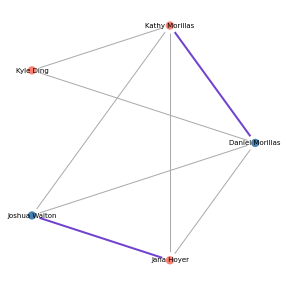

/usr/local/lib/python3.9/dist-packages/igraph/io/files.py:494: RuntimeWarning: The boolean edge attribute 'married' was converted to numeric. at src/io/gml.c:1281
  return writer(f, *args, **kwds)


In [17]:
import igraph as ig
import matplotlib.pyplot as plt

# Construct a graph with 5 vertices
n_vertices = 5
edges = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (3, 4)]
g = ig.Graph(n_vertices, edges)

# Set attributes for the graph, nodes, and edges
g["title"] = "Small Social Network"
g.vs["name"] = ["Daniel Morillas", "Kathy Archer", "Kyle Ding", "Joshua Walton", "Jana Hoyer"]
g.vs["gender"] = ["M", "F", "F", "M", "F"]
g.es["married"] = [False, False, False, False, False, False, False, True]

# Set individual attributes
g.vs[1]["name"] = "Kathy Morillas"
g.es[0]["married"] = True

# Plot in matplotlib
# Note that attributes can be set globally (e.g. vertex_size), or set individually using arrays (e.g. vertex_color)
fig, ax = plt.subplots(figsize=(5,5))
ig.plot(
    g,
    target=ax,
    layout="circle", # print nodes in a circular layout
    vertex_size=0.1,
    vertex_color=["steelblue" if gender == "M" else "salmon" for gender in g.vs["gender"]],
    vertex_frame_width=4.0,
    vertex_frame_color="white",
    vertex_label=g.vs["name"],
    vertex_label_size=7.0,
    edge_width=[2 if married else 1 for married in g.es["married"]],
    edge_color=["#7142cf" if married else "#AAA" for married in g.es["married"]]
)

plt.show()

# Save the graph as an image file
fig.savefig('social_network.png')
fig.savefig('social_network.jpg')
fig.savefig('social_network.pdf')

# Export and import a graph as a GML file.
g.save("social_network.gml")
g = ig.load("social_network.gml")

In [25]:
pip -q install osmnx rioxarray datashader contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 4.8 MB/s eta 0:00:00


In [26]:
import pandas
import osmnx
import geopandas
import rioxarray
import xarray
import datashader
import contextily as cx
from shapely import geometry
import matplotlib.pyplot as plt

```
clusters_para_all.py
```



In [15]:
#Conducts a k-means clustering of the points from any one text
#It outputs the number of place names from each cluster in each paragraph
#  both as a list of individual places and as a summary of number of
#  instances in each para by cluster
#v2: Allows the random function to be seeded for k-means
#    Adds word number to setNameCoords

def setNameCoords (placeNamesFileName, stNameColNo=8, latColNo=5, longColNo=4):
    #Creates an dictionary of stNames with details about each unique place name
    #The details are read in from the placeNamesFileName
    import csv
    class topoCoord:
        def __init__ (self, lat, long):
            try:
                self.lat=float(lat)
                self.long=float(long)
            except ValueError:
                self.lat=lat
                self.long=long
                print(f'Error in coordinates: {lat}, {long}')
            #print(self.bngX, self.bngY)
    nameCoords={}
    with open(placeNamesFileName, encoding='utf-8') as f:
        csvReader=csv.reader(f, delimiter=',')
        firstRow=True
        for row in csvReader:
            if firstRow:
                firstRow=False
            else:
                if row[stNameColNo] not in nameCoords.keys():
                    nameCoords[row[stNameColNo]]=topoCoord(row[latColNo],row[longColNo])
    print(f'{len(nameCoords.keys())} unique names read in from {placeNamesFileName}')
    return nameCoords

def isInLD (lat, long):
    #Returns true if the lat long is in the LD bounding box
    #  or false otherwise
    # LDBBox=[-3.65, 54.0, -2.30, 54.9]   #This was used initially
    LDBBox=[-4.60, 54.0, -2.50, 55.0]   #This is the definition used in the AAAG paper
    inLD=False
    try:
        if float(long)>=float(LDBBox[0]) and float(long)<=float(LDBBox[2]):
            if float(lat)>=float(LDBBox[1]) and float(lat)<=float(LDBBox[3]):
                inLD=True
    except ValueError: print(f'SN_tools isInLD could not locate {lat}, {long}')
    return(inLD)

def setFirstSent(inFileName, firstSent={}):
    #Returns a dictionary with keys as para and values as the sentence no of the first sentence in the para
    paraStart='<p><s id="s'   #Indicates the start of a para
    altStart='<p> <s id="s'    #An alternative start of a para
    paraNo=1
    with open(inFileName, encoding='utf-8') as inFile:
        fileText=inFile.read()
    fileText=fileText.replace(altStart, paraStart)
    while fileText.count(paraStart)>0:
        firstSent[paraNo]=between(fileText, paraStart, '"')
        fileText=after(fileText, paraStart)
        paraNo+=1
    return firstSent

def findParaNo(sentNo, firstSent):
    #Returns the para that a sentence is in
    #Relies in setFirstSent having been run first to create firstSent
    for thisPara in firstSent.keys():
        if int(sentNo)<int(firstSent[thisPara]):
            return thisPara-1
        lastParaNo=thisPara
    return(lastParaNo)

def setParaPlaceNames(placeNamesFileName, fileId, firstSent, idColNo=1, sentColNo=0, stNameColNo=8, wordNoColNo=3):
    #Creates a dictionary (paraPlaceNames) with the para number as a key
    #   and a list of the place names in the para as values
    #These flag the various columns in the placeNames file
    import csv
    paraPlaceNames={}
    with open(placeNamesFileName, encoding='utf-8') as f:
        csvReader=csv.reader(f, delimiter=',')
        firstRow=True
        for row in csvReader:
            if firstRow:
                firstRow=False
            else:
                if row[idColNo]==fileId:
                    sentNo=int(after(row[sentColNo], 's'))
                    try:
                        wordNo=int(after(row[wordNoColNo], 'w'))
                    except ValueError:
                        print (f'Failed to find wordNo for {after(row[wordNoColNo], "w")}')
                        wordNo=-999
                    paraNo=findParaNo(sentNo, firstSent)
                    if paraNo in paraPlaceNames.keys():
                        paraPlaceNames[paraNo].append(row[stNameColNo])
                    else: paraPlaceNames[paraNo]=[row[stNameColNo]]
    return paraPlaceNames        

def after(myStr, delim):
    #Returns the part of a string after the first occurence of the delimiter
    afterStr=myStr[myStr.find(delim)+len(delim):]
    return afterStr

def before(myStr, delim):
    #Returns the part of a string before the first occurence of the delimiter
    beforeStr=myStr[:myStr.find(delim)]
    return beforeStr

def between(myStr, startDelim, endDelim):
    #Returns the part of a string between two delimiters
    #'a <b>text<\\b> string', <b>, <\\b> will return 'text'
    #If startDelim and endDelim are the same it will
    # return the text between the first and second occurrence
    # ie. 'ab_cde_fg' with a delimter _ will return 'cde'
    afterStr=after(myStr, startDelim)
    betweenStr=before(afterStr, endDelim)
    return betweenStr

#MAIN CODE
# from osconv import *
#from corpus_funcs import *   #Imports before, after and between
from math import fabs
from math import sqrt

#User variables
corpusDir="/content/demo/"
geoParsedXmlFileName='Carter_cqp_52.xml'
fileId='1827_b'   #The Id from the placenames file (below)
placeNamesFileName= "LDv5_corpus_pl_names.xlsx" #'LDv5_corpus_pl_names.csv'
maxK=20   #The max number of clusters
minK=4    #The min number of clusters
useSeed=True   #Flags whether we want to seed the random part of k-means
outFileName=fileId+'test.csv'

geoParsedXmlFileName=corpusDir+geoParsedXmlFileName

#Read in the points from a geoparsed file
nameCoords=setNameCoords(placeNamesFileName)
#print(f'HERE {nameCoords.keys()}')
#for thisStName in nameCoords.keys():
#    print(f'{thisStName}, {nameCoords[thisStName].lat}, {nameCoords[thisStName].lat}') 

#Find the first sentence number of each para
firstSent=setFirstSent(geoParsedXmlFileName)
#for thisPara in firstSent.keys():
#    print(f'Para {thisPara} starts at sentence {firstSent[thisPara]}')

#Gives a list of place names in each para
paraPlaceNames=setParaPlaceNames(placeNamesFileName, fileId, firstSent)
#for thisPara in paraPlaceNames.keys():
#    print(f'Para {thisPara} has the follow names: {paraPlaceNames[thisPara]}')

#Create a list of all of the points in the text as BNG coordinates
points=[]       #This holds the BNGs of places inside the LD
names=[]        #This holds the names of places inside the LD
paraNos=[]
cluster999=[]   #This is the out cluster for places outside the LD
cluster999para=[]
for thisPara in paraPlaceNames.keys():
    for thisName in paraPlaceNames[thisPara]:
        if isInLD(nameCoords[thisName].lat, nameCoords[thisName].long):
            bngX, bngY=ll_to_os(float(nameCoords[thisName].lat), float(nameCoords[thisName].long))
        #print(f'{thisName}, {bngX}, {bngY}')
            points.append(Point(bngX, bngY))
            names.append(thisName)
            paraNos.append(thisPara)
        else:
            cluster999.append(thisName)
            cluster999para.append(thisPara)
            
print(f'{len(points)} points created from {fileId} in {geoParsedXmlFileName}\n')

#Now do the cluster analysis
totaldist, means, nearests, k=optimalKmeans(points, minK=minK, maxK=maxK, init="forgy", seedRandom=useSeed)
print(f'\nTotal dist: {totaldist}')


paraK={}   #Holds a list that counts the number of members of each cluster in each para. The keys are the para nos
initPara=[]

#This will hold the number of members in each cluster. For now we are just initiating it
for paraNo in range(1, 1+max(paraPlaceNames.keys())):
    paraK[paraNo]=[]
    for i in range(k+1):   #The plus 1 is for cluster 999
        paraK[paraNo].append(0)

with open(outFileName, 'w', encoding='utf-8') as f:
    f.write('St_Name,Lat,Long,ParaNo,ClusterNo\n')
    for i in range(len(nearests)):
        print(f'Cluster {i}: Centre: {means[i]}, Members: {len(nearests[i])}')
        for thisMember in nearests[i]:
            #print(f'{thisMember}, {names[thisMember]}: {nameCoords[names[thisMember]].lat}, {nameCoords[names[thisMember]].long}')
            f.write('"'+names[thisMember]+'",'+str(nameCoords[names[thisMember]].lat)+','+str(nameCoords[names[thisMember]].long)+','+str(paraNos[thisMember])+','+str(i)+'\n')
            #print(f'{paraNos[thisMember]}, {i}')
            paraK[paraNos[thisMember]][i]+=1 
    print(f'Cluster 999: {len(cluster999)} places outside the Lake District')
    cnt=0
    for thisName in cluster999:
        #print(f'     {thisName}, {nameCoords[thisName].lat}, {nameCoords[thisName].long}') 
        f.write('"'+thisName+'",'+str(nameCoords[names[thisMember]].lat)+','+str(nameCoords[names[thisMember]].long)+','+str(cluster999para[cnt])+',999\n')
        paraK[cluster999para[cnt]][-1]+=1
        #print(f'{cluster999para[cnt]}')
        cnt+=1
print(f'\n{k} clusters from {geoParsedXmlFileName} written to {outFileName}')

with open(outFileName.replace('.csv','_byPara.csv'), 'w', encoding='utf-8') as f:
    f.write('ParaNo')
    for clust in range(k):
        f.write(',Cluster '+str(clust))
    f.write(',Cluster 999\n')
    for paraNo in range(1, 1+max(paraPlaceNames.keys())):
        f.write(str(paraNo))
        for clust in range(k+1):
            f.write(','+str(paraK[paraNo][clust]))
        f.write('\n')
            
print(f'Summaries written to {outFileName.replace(".csv","_byPara.csv")}')

#for thisPara in paraK.keys():
#    print(f'{thisPara}, {paraK[thisPara]}')

UnicodeDecodeError: ignored

In [ ]:
'''
A class for points used in the GIS Algorithms book.
Change history
  December 10, 2022
    Now use *args and **kwargs in __init__ to make it more flexible
  September 30, 2017
    Change __repr__ to return a new string like 'Point(x,y)'
  April 24, 2017
    Remove long from isinstance. Python 3 no longer support long
  March 1, 2017
    More updates on __str__ to make sure integers are printed correctly.
  October 28, 2015
    Functions __repr__ and __str__ are updated to be more flexible and robust.
  November 10, 2015
    Add a key member to the class

Contact:
Ningchuan Xiao
The Ohio State University
Columbus, OH
'''
__author__ = 'Ningchuan Xiao <ncxiao@gmail.com>'

from math import sqrt

class Point:
    '''
    A class for points in Cartesian coordinate systems.
    Examples: 
    A Point object at (10, 1) with an attribute of 100 can be created using the following:
        Point(10, 1, 100) 
        Point(x=10, y=1, key=100)
    These are also valid examples:
        Point(10)
        Point(10, 1)
        Point(x=10, y=1)
    '''

    def __init__(self, *args, **kwargs): # x=None, y=None, key=None):
        self.x = None
        self.y = None
        self.key = None
        if len(args) == 1:
            if isinstance(args[0], (list, tuple)):
                if len(args[0]) == 2:
                    self.x = args[0][0]
                    self.y = args[0][1]
            else:
                self.x = args[0]
        elif len(args) == 2:
            self.x = args[0]
            self.y = args[1]
            self.key = None
        elif len(args) == 3:
            self.x = args[0]
            self.y = args[1]
            self.key = args[2]
        else:
            if 'x' in kwargs.keys():
                self.x = kwargs['x']
            if  'y' in kwargs.keys():
                self.y = kwargs['y']
            if 'key' in kwargs.keys():
                self.key = kwargs['key']
    def __getitem__(self, i):
        if i==0: return self.x
        if i==1: return self.y
        return None
    def __len__(self):
        return 2
    def __eq__(self, other):
        if isinstance(other, Point):
            return self.x==other.x and self.y==other.y
        return NotImplemented
    def __ne__(self, other):
        result = self.__eq__(other)
        if result is NotImplemented:
            return result
        return not result
    def __lt__(self, other):
        if isinstance(other, Point):
            if self.x<other.x:
                return True
            elif self.x==other.x and self.y<other.y:
                return True
            return False
        return NotImplemented
    def __gt__(self, other):
        if isinstance(other, Point):
            if self.x>other.x:
                return True
            elif self.x==other.x and self.y>other.y:
                return True
            return False
        return NotImplemented
    def __ge__(self, other):
        if isinstance(other, Point):
            if self > other or self == other:
                return True
            else:
                return False
            return False
        return NotImplemented
    def __le__(self, other):
        if isinstance(other, Point):
            if self < other or self == other:
                return True
            else:
                return False
            return False
        return NotImplemented
    def isvalid(self):
        if not isinstance(self.x, (int, float)) \
                or not isinstance(self.y, (int, float)):
            return False
        return True
    def __str__(self):
        '''NaP: Not a point'''
        if not self.isvalid():
            return 'NaP'
        if isinstance(self.x, (int)):
            fmtstr = '({0}, '
        else:
            fmtstr = '({0:.1f}, '
        if isinstance(self.y, (int)):
            fmtstr += '{1})'
        else:
            fmtstr += '{1:.1f})'
        return fmtstr.format(self.x, self.y)
    def __repr__(self):
        return 'Point({}, {})'.format(self.x, self.y)
    def distance(self, other):
        return sqrt((self.x-other.x)**2 + (self.y-other.y)**2)

In [ ]:
#For a kmeans for a set value of K use kmeans
#To select a value of K use optimalKmeans
import random
from math import fabs
from math import sqrt

INF=float('inf')

def clustering_dist(points, means):
    n=len(points)
    k=len(means)
    nearests=[[] for i in range(k)]
    totaldist=0
    for i in range(n):
        dmin=INF
        near=[]
        for j in range(k):
            d=points[i].distance(means[j])
            if d<dmin:
                dmin=d
                jmin=j
        totaldist+=dmin
        nearests[jmin].append(i)
    totaldist=totaldist/n
    return nearests, totaldist

def initk(points, k, init):
    n=len(points)
    xmin=INF
    ymin=INF
    xmax=-INF
    ymax=-INF
    for p in points:
        xmin=min([xmin, p.x])
        ymin=min([ymin, p.y])
        xmax=max([xmax, p.x])
        ymax=max([ymax, p.y])
    nearests=[[] for i in range(k)]
    while [] in nearests:
        if init=="forgy":
            means=[points[i] for i in random.sample(range(n), k)]
        elif init=="random":
            means=[Point(random.uniform(xmin, xmax), random.uniform(ymin,ymax)) for i in range(k)]
        else:
            print("Error: unknown initialisation method")
            sys.exit(1)
        nearests, totaldist=clustering_dist(points, means)
    return means, nearests, totaldist

def kmeans (points, k, threshold=5, init="forgy"):
    bigdiff=True
    means, nearests, totaldist=initk(points, k, init)
    #print(nearests)
    cnt=1
    while bigdiff:
        means2=[]
        for j in range(k):
            cluster=[xx for xx in nearests[j]]
            sumx=sum([points[ii].x for ii in cluster])
            sumy=sum([points[ii].y for ii in cluster])
            numpts=len(nearests[j])
            if numpts>0:
                sumx=sumx/numpts
                sumy=sumy/numpts
            means2.append(Point(sumx, sumy))
        nearests, newtotal=clustering_dist(points, means2)
        offset=totaldist-newtotal
        #print(f'Iteration {cnt}: {offset} (threshold={threshold})')
        cnt+=1
        if offset>threshold:
            means=means2
            totaldist=newtotal
        else:
            bigdiff=False
    #print(nearests)        
    return totaldist, means, nearests

def optimalKmeans(points, minK=2, maxK=10, init="forgy", seedRandom=False):
    #Selects the optimal value of K using something like the elbow method
    #and then runs kmeans with that value of K to return the results
    distChanges={}
    sumChange=0
    denomChange=0
    if seedRandom:
        random.seed(126341)
    print(f'Checking for optimal value of K (min K={minK}, max K={maxK})')
    for k in range(2,maxK+1):
        totaldist, means, nearests=kmeans(points, k, init="forgy")
        if k==2:
            lastDist=totaldist
            distChange=100
        else:
            distChange=100.0*(lastDist-totaldist)/lastDist
            distChanges[k]=distChange
            lastDist=totaldist
            if distChange>=0.0:
                sumChange+=distChange
            denomChange+=1

        print(f'For {k} clusters total dist is {totaldist} a change of {distChange}%')
    avChange=sumChange/denomChange
    print(f'Average change positive: {avChange}')
    for thisK in distChanges.keys():
        if distChanges[thisK]<avChange and thisK >= minK:
            optimalK=thisK
            break
    print(f'Optimal value of K: {optimalK}')
    totaldist, means, nearests=kmeans(points, optimalK, init="forgy")
    return totaldist, means, nearests, optimalK

def test():
    n=500   #The number of points to cluster
    #k=10    #The number of clusters to form
    maxK=10
    points=[Point(random.uniform(1,100000), random.uniform(1,100000)) for i in range(n)]
    #print(points)
    totaldist, means, nearests=optimalKmeans(points)
    for i in range(len(nearests)):
        print(f'Cluster {i}: Centre: {means[i]}, Members: {nearests[i]}')
    print (f'Total dist: {totaldist}')
    for i in range(len(means)):
        print(f'Cluster {i} centre: {means[i]}')
    
    #print (f'1: {kmeans(points, 10, init="forgy")}')
    points1=[Point(random.uniform(10,20), random.uniform(10,20)) for i in range(int(n/2))]
    points2=[Point(random.uniform(30,40), random.uniform(30,40)) for i in range(int(n/2))]
    #print(f'2: {kmeans(points1+points2, 2)[0]}')
    points1=[Point(random.uniform(10,20), random.uniform(10,20)) for i in range(int(n/3))]
    points2=[Point(random.uniform(30,40), random.uniform(10,20)) for i in range(int(n/3))]
    points3=[Point(random.uniform(20,30), random.uniform(30,40)) for i in range(int(n/3))]

    #print(f'3: {kmeans(points1+points2+points3, 3)[0]}')
    #print(f'4: {kmeans(points1+points2+points3, 3, init="random")[0]}')

if __name__=="__main__":
    test()


In [ ]:
### clusters_para_all.py ###
# Import the CSV module for working with CSV files
import csv

# Define a class to store coordinates (latitude and longitude)
# If a coordinate value cannot be converted to float, it will be stored as a string
class TopoCoord:
    def __init__(self, lat, long):
        try:
            self.lat = float(lat)
            self.long = float(long)
        except ValueError:
            self.lat = lat
            self.long = long
            print(f"Error in coordinates: {lat}, {long}")

# This function reads in a file containing place names and their coordinates
# It returns a dictionary where each key is a unique place name
# and each value is a TopoCoord object containing the place's latitude and longitude
def setNameCoords(placeNamesFileName, stNameColNo=8, latColNo=5, longColNo=4):
    # Create an empty dictionary to store place name coordinates
    nameCoords = {}
    # Open the input file
    with open(placeNamesFileName, encoding="utf-8") as f:
        # Use the CSV module to read in each row
        csvReader = csv.reader(f, delimiter=",")
        # Skip the first row (header row)
        firstRow = True
        # For each subsequent row, extract the place name and coordinates
        for row in csvReader:
            if firstRow:
                firstRow = False
            else:
                stName = row[stNameColNo]
                # If this is the first time we've seen this place name, add it to the dictionary
                if stName not in nameCoords.keys():
                    nameCoords[stName] = TopoCoord(row[latColNo], row[longColNo])
    # Print the number of unique place names that were read in
    print(f"{len(nameCoords.keys())} unique names read in from {placeNamesFileName}")
    # Return the dictionary of place name coordinates
    return nameCoords

# This function checks whether a given latitude and longitude is within the bounding box of the Lake District
# It returns True if the coordinates are within the box, and False otherwise
def isInLD(lat, long):
    # Define the bounding box coordinates for the Lake District
    # This version uses the coordinates from the paper "Automatic Extraction of Walk Descriptions from Blog Posts" by AAAG (http://aclweb.org/anthology/E17-3010)
    LDBBox = [-4.60, 54.0, -2.50, 55.0]
    # Check if the given coordinates are within the bounding box
    try:
        if float(long) >= float(LDBBox[0]) and float(long) <= float(LDBBox[2]):
            if float(lat) >= float(LDBBox[1]) and float(lat) <= float(LDBBox[3]):
                return True
    except ValueError:
        print(f"SN_tools isInLD could not locate {lat}, {long}")
    return False

# This function reads in a file and returns a dictionary of the first sentence number for each paragraph
# The keys are paragraph numbers (starting at 1)
# The values are the sentence number of the first sentence in each paragraph
def setFirstSent(inFileName, firstSent={}):
    # Define the HTML tag that indicates the start of a paragraph
    paraStart = '<p><s id="s'
    # An alternative start of a para (used in some files)
    altStart = '<p> <s id="s'
    # Initialize the paragraph number to 1

```
kmeans_annotated.py
```

In [ ]:
def initk(points, k, init):
    xmin, ymin = min(p.x for p in points), min(p.y for p in points)
    xmax, ymax = max(p.x for p in points), max(p.y for p in points)
    nearests=[[] for i in range(k)]
    while [] in nearests:
        if init=="forgy":
            means=random.sample(points, k)
        elif init=="random":
            means=[Point(random.uniform(xmin, xmax), random.uniform(ymin,ymax)) for i in range(k)]
        else:
            print("Error: unknown initialisation method")
            sys.exit(1)
        nearests, totaldist=clustering_dist(points, means)
    return means, nearests, totaldist


def kmeans(points, k, threshold=5, init="forgy"):
    bigdiff=True
    means, nearests, totaldist=initk(points, k, init)
    cnt=1
    while bigdiff:
        means2 = [Point(sum(p.x for p in points[ii] in nearests[j])/len(nearests[j]), 
                        sum(p.y for p in points[ii] in nearests[j])/len(nearests[j]))
                  for j in range(k)]
        nearests, newtotal=clustering_dist(points, means2)
        offset=totaldist-newtotal
        cnt+=1
        if offset>threshold:
            means=means2
            totaldist=newtotal
        else:
            bigdiff=False
    return totaldist, means, nearests


In [ ]:
# Extract entities from text using spaCy
doc = nlp(text)
entities = [(entity.text, entity.label_) for entity in doc.ents]

# Filter out entities that are not locations
locations = []
for entity in entities:
    if entity[1] in ['GPE', 'PERSON', 'ORG']:
        locations.append(entity[0])

# Get coordinates for locations using GeoPy
geolocator = Nominatim(user_agent="my-application")
coordinates = []
for location in locations:
    location_data = geolocator.geocode(location)
    if location_data is not None:
        coordinates.append((location_data.latitude, location_data.longitude))

# Create map using Folium and add markers for locations
m = folium.Map(location=[coordinates[0][0], coordinates[0][1]], zoom_start=5)
for coord in coordinates:
    folium.Marker(location=[coord[0], coord[1]]).add_to(m)

# Display map
m


In [ ]:
import spacy
from spacy import displacy

# Load the NER model
nlp = spacy.load("en_core_web_sm")

# Define a function to extract entities and their relationships from text
def extract_entities(text):
    doc = nlp(text)
    entities = []
    relations = []

    # Extract named entities
    for ent in doc.ents:
        if ent.label_ == "GPE" or ent.label_ == "LOC":
            entities.append(ent)

    # Extract relationships between named entities
    for chunk in doc.noun_chunks:
        subj = None
        obj = None
        for ent in entities:
            if ent.text == chunk.text:
                if not subj:
                    subj = ent
                else:
                    obj = ent
                    break
        if subj and obj:
            relations.append((subj, obj))

    return entities, relations


# Define a function to disambiguate locations
def disambiguate_locations(entities):
    # Create a set of unique location names
    unique_locs = set()
    for entity in entities:
        unique_locs.add(entity.text)

    # Disambiguate location names
    for loc in unique_locs:
        count = 0
        for entity in entities:
            if entity.text == loc:
                count += 1
                if count > 1:
                    entity._.is_ambiguous = True
                else:
                    entity._.is_ambiguous = False

# Define a function to plot entities and their relationships on a map
def plot_map(entities, relations):
    options = {"ents": ["GPE", "LOC"], "colors": {"GPE": "orange", "LOC": "green"}}
    if entities:
        disambiguate_locations(entities)
        displacy.render(entities, style="ent", jupyter=True, options=options)
    if relations:
        displacy.render(relations, style="dep", jupyter=True, options=options)

# Extract entities and their relationships from multiple sentences
sentences = ["I live in New York and work in Boston.", "My friend works in Chicago but also visits Los Angeles."]
entities, relations = [],[]
for sentence in sentences:
    sent_entities, sent_relations = extract_entities(sentence)
    entities += sent_entities
    relations += sent_relations

# Plot entities and their relationships on a map
plot_map(entities, relations)

In [ ]:
import geopy
import folium

# Define the bounding box
bbox = [(54.0, -4.60), (55.0, -2.50)]

# Define the list of place names
places = ['London', 'Edinburgh', 'Birmingham', 'Bristol', 'Cardiff', 'Glasgow']

# Create a map centered on the bounding box with smaller width and height
map = folium.Map(location=[(bbox[0][0]+bbox[1][0])/2, (bbox[0][1]+bbox[1][1])/2], zoom_start=8, tiles='Stamen Toner', width=500, height=300)

# Create two feature groups to store the markers for the places within and outside the bounding box
inside_bbox = folium.FeatureGroup(name='Inside Bounding Box')
outside_bbox = folium.FeatureGroup(name='Outside Bounding Box')

# Loop through each place name and get its coordinates
for place in places:
    location = geopy.geocoders.Nominatim(user_agent="my-application").geocode(place)
    lat, lon = location.latitude, location.longitude
    
    # Check if the coordinates are within the bounding box
    if bbox[0][1] <= lon <= bbox[1][1] and bbox[0][0] <= lat <= bbox[1][0]:
        # Add a marker to the inside_bbox feature group
        folium.Marker(location=[lat, lon], tooltip=place, icon=folium.Icon(color='green', icon='info-sign'), popup=place).add_to(inside_bbox)
    else:
        # Add a marker to the outside_bbox feature group
        folium.Marker(location=[lat, lon], tooltip=place, icon=folium.Icon(color='red', icon='info-sign'), popup=place).add_to(outside_bbox)

# Add the feature groups to the map
inside_bbox.add_to(map)
outside_bbox.add_to(map)

# Add a layer control to toggle between the feature groups
folium.LayerControl().add_to(map)

# Display the map
map

# Part 2